# Neurosymbolic Software Tutorial - NEAR Bouncing Ball

<a target="_blank" href="https://colab.research.google.com/github/kavigupta/neurosym-lib/blob/main/tutorial/bouncing_ball_exercise_solutions.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Instruction
- Navigating this notebook on Google Colab: There will be text blocks and code blocks throughout the notebook. The text blocks, such as this one, will contain instructions and questions for you to consider. The code blocks, such as the one below, will contain executible code. Sometimes you will have to modify the code blocks following the instructions in the text blocks. You can run the code block by either pressing control/cmd + enter or by clicking the arrow on left-hand side.
- Saving Work: If you wish to save your work in this .ipynb, we recommend downloading the compressed repository from GitHub, unzipping it, uploading it to Google Drive, and opening this notebook from within Google Drive.

## Notebook

In this notebook, you will construct a DSL to simulate a bouncing ball

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
import os

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import neurosym as ns
from neurosym.examples import near

pl = ns.import_pytorch_lightning()


In [2]:
torch.manual_seed(0)
np.random.seed(0)

## Data

We then load and plot some bouncing ball trajectories. Note that these trajectories are represented as a list `[x, y, vx, vy]`

In [3]:
dataset_factory = lambda train_seed: ns.DatasetWrapper(
    ns.DatasetFromNpy(
        f"bouncing_ball_exercise/data/bounce_example/train_ex_data.npy",
        f"bouncing_ball_exercise/data/bounce_example/train_ex_labels.npy",
        train_seed,
    ),
    ns.DatasetFromNpy(
        f"bouncing_ball_exercise/data/bounce_example/test_ex_data.npy",
        f"bouncing_ball_exercise/data/bounce_example/test_ex_labels.npy",
        None,
    ),
    batch_size=200,
)
datamodule = dataset_factory(42)

In [4]:
def plot_trajectory(trajectory, color):
    plt.scatter(trajectory[:, 0], trajectory[:, 1], marker="o", color=color)
    plt.plot(trajectory[:, 0], trajectory[:, 1], alpha=0.2, color=color)
    plt.xlim(-5, 10)
    plt.ylim(-5, 7)
    plt.grid(True)

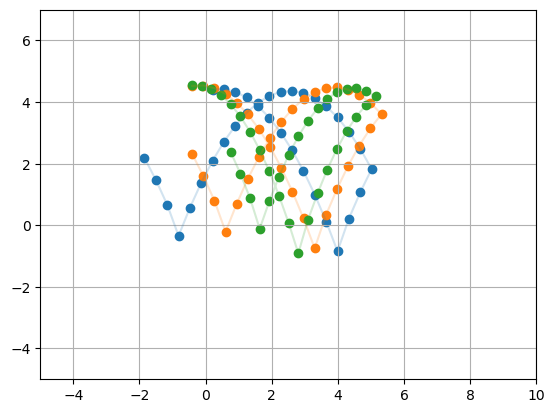

In [5]:
for i in range(3):
    plot_trajectory(datamodule.train.inputs[i], f"C{i}")

In [6]:
print("input[0] :", datamodule.train.inputs[i, 0])
print("output[0]:", datamodule.train.outputs[i, 0])

input[0] : [-0.40642968  4.5408607   2.9196808  -0.05576635]
output[0]: [-0.11446159  4.535284    2.9196808  -1.0357664 ]


## Exercise: DSL

Fill in the `bounce_dsl` to parameterize the space of functions that could represent the trajectories of bouncing balls.

In [7]:
def bounce_dsl():
    L = 4
    O = 4
    dslf = ns.DSLFactory(L=L, O=O, max_overall_depth=5)
    # BEGIN SOLUTION "YOUR CODE HERE"
    ## DSL for the bounce example.
    dslf.typedef("fL", "{f, $L}")

    dslf.parameterized(
        "linear_bool",
        "() -> $fL -> f",
        lambda lin: lin,
        dict(lin=lambda: nn.Linear(L, 1)),
    )
    dslf.parameterized(
        "linear", "() -> $fL -> $fL", lambda lin: lin, dict(lin=lambda: nn.Linear(L, L))
    )

    dslf.concrete("ite", "(#a -> f, #a -> #a, #a -> #a) -> #a -> #a", near.operations.ite_torch)
    dslf.concrete(
        "map", "(#a -> #b) -> [#a] -> [#b]", lambda f: lambda x: near.operations.map_torch(f, x)
    )
    # END SOLUTION
    dslf.prune_to("[$fL] -> [$fL]")
    return dslf.finalize()

In [8]:
dsl = bounce_dsl()

### DSL Printout

See your DSL printed below, and ensure it is what you would expect

In [9]:
print(dsl.render())

            ite :: (#a -> f, #a -> #a, #a -> #a) -> #a -> #a
            map :: (#a -> #b) -> [#a] -> [#b]
linear_bool[lin] :: () -> {f, 4} -> f
    linear[lin] :: () -> {f, 4} -> {f, 4}


### Setting up Neural DSL

In [10]:
input_dim, output_dim = 4, 4
max_depth = 16

In [11]:
t = ns.TypeDefiner(L=input_dim, O=output_dim)
t.typedef("fL", "{f, $L}")
neural_modules = {
        **near.create_modules(
            "mlp",
            [t("($fL) -> $fL")],
            near.mlp_factory(hidden_size=10),
        ),
        **near.create_modules(
            "rnn_seq2seq",
            [t("([$fL]) -> [$fL]")],
            near.rnn_factory_seq2seq(hidden_size=10),
        ),
    }

In [12]:

interface = near.NEAR(
    input_dim=input_dim,
    output_dim=output_dim,
    max_depth=max_depth,
    lr=1e-3,
    max_seq_len=300,
    n_epochs=100,
    accelerator="cpu",
)
interface.register_search_params(
    dsl=dsl,
    type_env=t,
    neural_modules=neural_modules,
    search_strategy=ns.search.bounded_astar,
    loss_callback=torch.nn.functional.mse_loss,
    validation_params=dict(
            enable_progress_bar=False,
    enable_model_summary=False,
    progress_by_epoch=True,

    )
)

In [13]:
# logging.getLogger("pytorch_lightning.utilities.rank_zero").setLevel(logging.WARNING)
# logging.getLogger("pytorch_lightning.accelerators.cuda").setLevel(logging.WARNING)


# trainer_cfg = near.NEARTrainerConfig(
#     lr=5e-3,
#     max_seq_len=300,
#     n_epochs=100,
#     num_labels=output_dim,
#     train_steps=len(datamodule.train),
#     loss_callback=torch.nn.functional.mse_loss,
#     scheduler="cosine",
#     optimizer=torch.optim.Adam,
# )

# validation_cost = near.ValidationCost(
#     neural_dsl=neural_dsl,
#     trainer_cfg=trainer_cfg,
#     datamodule=datamodule,
#     callbacks=[
#         pl.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5)
#     ],
#     enable_progress_bar=False,
#     enable_model_summary=False,
#     progress_by_epoch=True,
# )

# g = near.near_graph(
#     neural_dsl,
#     ns.parse_type(
#         s="([{f, $L}]) -> [{f, $O}]", env=ns.TypeDefiner(L=input_dim, O=output_dim)
#     ),
#     is_goal=neural_dsl.program_has_no_holes,
#     max_depth=max_depth
# )


### Run NEAR

In [11]:
# iterator = ns.search.bounded_astar(g, validation_cost, max_depth=max_depth)
# best_program_nodes = []
# # Let's collect the top four programs
# while len(best_program_nodes) <= 3:
#     try:
#         node = next(iterator)
#         cost = validation_cost(node)
#         best_program_nodes.append((node, cost))
#         print("Got another program")
#     except StopIteration:
#         print("No more programs found.")
#         break
best_programs = interface.fit(
    datamodule=datamodule,
    program_signature="([{f, $L}]) -> [{f, $O}]",
    n_programs=3
)

Training ??::<[{f, 4}] -> [{f, 4}]>
Training (ite ??::<[{f, 4}] -> f> ??::<[{f, 4}] -> [{f, 4}]> ??::<[{f, 4}] -> [{f, 4}]>)
Partial Program not found for (ite ??::<[{f, 4}] -> f> ??::<[{f, 4}] -> [{f, 4}]> ??::<[{f, 4}] -> [{f, 4}]>)
Training (map ??::<{f, 4} -> {f, 4}>)
Training (__neural_dsl_internal_rnn_seq2seq_1)
Training (map (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>))
Partial Program not found for (map (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>))
Training (map (linear))
Training (map (__neural_dsl_internal_mlp_1))
Training (map (linear))
Got another program
Training (map (ite (linear_bool) ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>))
Training (map (ite (linear_bool) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>) ??::<{f, 4} -> {f, 4}>))
Partial Program not found for (map (ite (linear_bool) (ite ??::<{f, 4} -> f> ??::<{f, 4} -> {f, 4}> ??::<{f, 4} -> {f, 4}>) ??::<{f, 4} -> {f, 4}>))
Training (map (ite

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

### Top 3 Programs

The code below assumes you found some top 3 programs and stored them in the best_program_nodes variable.

In [12]:
best_program_nodes = sorted(best_program_nodes, key=lambda x: x[1])
for i, (node, cost) in enumerate(best_program_nodes):
    print(
        "({i}) Cost: {cost:.4f}, {program}".format(
            i=i, program=ns.render_s_expression(node.program), cost=cost
        )
    )

(0) Cost: 3.4594, (map (ite (linear_bool) (linear) (ite (linear_bool) (linear) (linear))))
(1) Cost: 3.9734, (map (ite (linear_bool) (linear) (linear)))
(2) Cost: 4.6332, (map (ite (linear_bool) (ite (linear_bool) (linear) (linear)) (linear)))
(3) Cost: 7.1405, (map (linear))


The function below is set up to further fine tune the program, test it, and return a set of values produced by it.

In [13]:
def testProgram(best_program_node):
    module = near.TorchProgramModule(
        dsl=neural_dsl, program=best_program_node[0].program
    )
    pl_model = near.NEARTrainer(module, config=trainer_cfg)
    trainer = pl.Trainer(
        max_epochs=4000,
        devices="auto",
        accelerator="cpu",
        enable_checkpointing=False,
        logger=False,
        callbacks=[
            pl.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5)
        ],
        enable_progress_bar=False,
    )

    trainer.fit(pl_model, datamodule.train_dataloader(), datamodule.val_dataloader())
    T = 100
    path = np.zeros((T, 4))
    X = torch.tensor(
        np.array([0.21413583, 4.4062634, 3.4344807, 0.12440437]), dtype=torch.float32
    )
    for t in range(T):
        path[t, :] = X.detach().numpy()
        Y = module(X.unsqueeze(0)).squeeze(0)
        X = Y
    return path

In [14]:
trajectories = [testProgram(prog) for prog in best_program_nodes]


  | Name  | Type               | Params | Mode 
-----------------------------------------------------
0 | model | TorchProgramModule | 70     | train
-----------------------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size (MB)

  | Name  | Type               | Params | Mode 
-----------------------------------------------------
0 | model | TorchProgramModule | 45     | train
-----------------------------------------------------
45        Trainable params
0         Non-trainable params
45        Total params
0.000     Total estimated model params size (MB)

  | Name  | Type               | Params | Mode 
-----------------------------------------------------
0 | model | TorchProgramModule | 70     | train
-----------------------------------------------------
70        Trainable params
0         Non-trainable params
70        Total params
0.000     Total estimated model params size 

## Plotting Trajectories

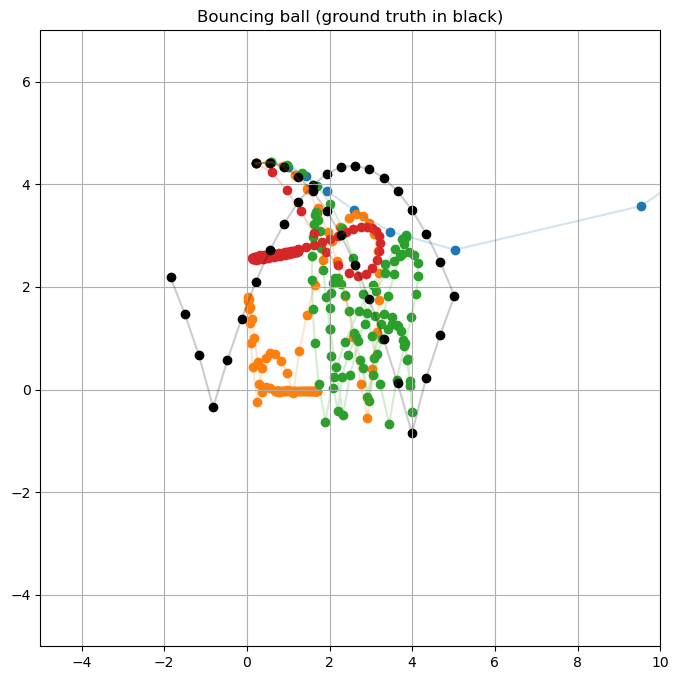

In [15]:
plt.figure(figsize=(8, 8))

for i, trajectory in enumerate(trajectories):
    plot_trajectory(trajectory, f"C{i}")
plot_trajectory(datamodule.train.inputs[0], "black")

plt.title("Bouncing ball (ground truth in black)")
plt.show()
